In [0]:
# load data and fit model
from pyspark.ml.classification import RandomForestClassifier

train_fin = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/train_fin.parquet")
test_fin = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/test_fin.parquet")

rf = RandomForestClassifier(labelCol="DEP_DEL15", featuresCol="features", maxBins = 369, numTrees=10, maxMemoryInMB=1000, weightCol="classWeights")
rf_model=rf.fit(train_fin)

In [0]:
# confusion matrix and accuracy, precision, recall
from pyspark.mllib.evaluation import MulticlassMetrics

rf_test_pred = rf_model.transform(test_fin)
predictions = [prediction[0] for prediction in rf_test_pred.select('prediction').collect()]
labels = [label[0] for label in rf_test_pred.select('DEP_DEL15').collect()]
predictionAndLabels = sc.parallelize(tuple(zip(predictions, labels)))

metrics = MulticlassMetrics(predictionAndLabels)
print("Test Accuracy = %s" % metrics.accuracy)
print("Test Precision = %s" % metrics.precision(1.0))
print("Test Recall = %s" % metrics.recall(1.0))
print('Confusion Matrix:')
print(metrics.confusionMatrix())

Test Accuracy = 0.8510005303352867
Test Precision = 0.5931693601996447
Test Recall = 0.5199760655435883
Confusion Matrix:
DenseMatrix([[4903591., 410652.],
 [ 552737., 598741.]])

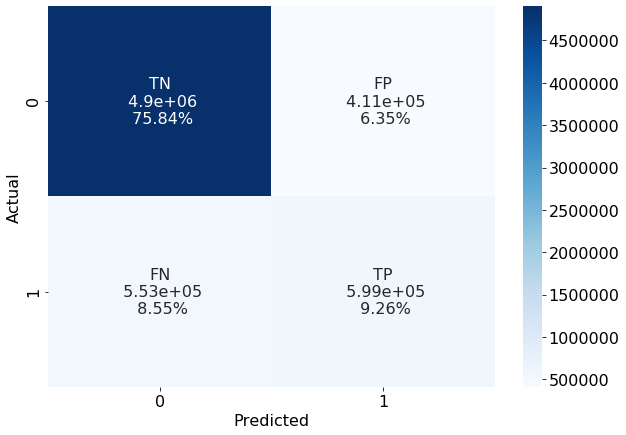

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

confusionMat = metrics.confusionMatrix().toArray()
percents = [str(round(quadrant/sum(confusionMat.flatten())*100, 2))+'%' for quadrant in confusionMat.flatten()]
labels = (np.asarray(["{0}\n {1:.3g}\n {2}".format(string, value, percent)
                      for string, value, percent in zip(['TN', 'FP', 'FN', 'TP']
                                                        , confusionMat.flatten()
                                                        , percents
                                                       )
                     ])
         ).reshape(2, 2)

figH, axH = plt.subplots(figsize=(10, 7))
axH = sns.heatmap(confusionMat, annot=labels, annot_kws={"fontsize":16}, fmt="", cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.rcParams.update({'xtick.labelsize': 16,
                    'ytick.labelsize': 16})

In [0]:
# AUROC, AUPRCurve, F1
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15")
print("Test AUROC", evaluator.setMetricName("areaUnderROC").evaluate(rf_test_pred))
print("Test Area under PR", evaluator.setMetricName("areaUnderPR").evaluate(rf_test_pred))

evaluator = MulticlassClassificationEvaluator(labelCol="DEP_DEL15")
print("Test F1", evaluator.setMetricName("f1").evaluate(rf_test_pred))
print("Test fMeasureByLabel", evaluator.setMetricName("fMeasureByLabel").evaluate(rf_test_pred))

Test AUROC 0.7770715443838908
Test Area under PR 0.5561513425226375
Test F1 0.8470847041291372
Test fMeasureByLabel 0.910553581606769